In [1]:
# General imports 
import os 
import re
import numpy as np
import pandas as pd
from pathlib import Path
import scipy.stats as stats 
from skimage import measure
import matplotlib.pyplot as plt

# Pynwb imports
from hdmf_zarr import NWBZarrIO
from nwbwidgets import nwb2widget

In [2]:
# set data path
import sys
import platform
from os.path import join as pjoin

platstring = platform.platform()
system = platform.system()
if system == "Darwin":
    # macOS
    data_dir = "/Volumes/Brain2025/"
elif system == "Windows":
    # Windows (replace with the drive letter of USB drive)
    data_dir = "E:/"
elif "amzn" in platstring:
    # then on CodeOcean
    data_dir = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_dir = "/media/$USERNAME/Brain2025/"
    
print('data directory set to', data_dir)

data directory set to /data/


In [3]:
sys.path.insert(0,'/code/src')
from bci.loaders import load 

In [4]:
metadata = pd.read_csv(os.path.join(data_dir, 'bci_task_metadata', 'bci_metadata.csv'))

In [5]:
metadata.value_counts(['subject_id'])

subject_id
731015        7
740369        7
754303        6
767715        6
772414        4
766719        3
Name: count, dtype: int64

In [8]:
# Pick the first mouse
subject_ids = np.sort(metadata['subject_id'].unique())
subject_id = 754303
print('Selected subject_id is', subject_id)

# Look at its metadata, sorted by 'session_number'
this_mouse_metadata = metadata[metadata['subject_id']==subject_id].sort_values(by='session_number')
this_mouse_metadata

Selected subject_id is 754303


,project_name,session_type,_id,name,subject_id,genotype,virus,date_of_birth,sex,modality,session_date,age,session_time,targeted_structure,ophys_fov,session_number
14,Brain Computer Interface,BCI single neuron stim,3aac9323-c4f9-4172-9f1a-6c12cb3bc44e,single-plane-ophys_754303_2025-01-22_18-22-38_...,754303,Camk2a-tTA/wt;TetO-jGCaMP8s-01/wt,pAAV-CaMKIIa-ChRmine-oScarlet-Kv2.1-WPRE - 7413,2024-07-17,Male,Planar optical physiology,2025-01-22,189,16:59:35.618000,Primary Motor Cortex,FOV_01,2.0
16,Brain Computer Interface,BCI single neuron stim,aaf560f4-bb1f-449a-aaf9-5054432b47ae,single-plane-ophys_754303_2025-01-23_19-48-32_...,754303,Camk2a-tTA/wt;TetO-jGCaMP8s-01/wt,pAAV-CaMKIIa-ChRmine-oScarlet-Kv2.1-WPRE - 7413,2024-07-17,Male,Planar optical physiology,2025-01-23,190,18:36:30.521000,Primary Motor Cortex,FOV_01,3.0
15,Brain Computer Interface,BCI single neuron stim,7efb85e4-0dba-43fe-a0fd-2b8348e05b69,single-plane-ophys_754303_2025-01-27_20-01-31_...,754303,Camk2a-tTA/wt;TetO-jGCaMP8s-01/wt,pAAV-CaMKIIa-ChRmine-oScarlet-Kv2.1-WPRE - 7413,2024-07-17,Male,Planar optical physiology,2025-01-27,194,18:46:54.109999,Primary Motor Cortex,FOV_01,5.0
17,Brain Computer Interface,BCI single neuron stim,5fa54429-8887-48b7-a3db-5526d7fa3fe5,single-plane-ophys_754303_2025-01-29_16-07-41_...,754303,Camk2a-tTA/wt;TetO-jGCaMP8s-01/wt,pAAV-CaMKIIa-ChRmine-oScarlet-Kv2.1-WPRE - 7413,2024-07-17,Male,Planar optical physiology,2025-01-29,196,16:07:41.655000,Primary Motor Cortex,FOV_01,6.0
18,Brain Computer Interface,BCI single neuron stim,737557e6-4bb3-423f-8fae-a2a63ee600e7,single-plane-ophys_754303_2025-01-31_15-13-50_...,754303,Camk2a-tTA/wt;TetO-jGCaMP8s-01/wt,pAAV-CaMKIIa-ChRmine-oScarlet-Kv2.1-WPRE - 7413,2024-07-17,Male,Planar optical physiology,2025-01-31,198,15:13:50.595999,Primary Motor Cortex,FOV_01,8.0
19,Brain Computer Interface,BCI single neuron stim,02859cbf-4099-4508-a2d1-6bad82ffcebb,single-plane-ophys_754303_2025-02-03_15-24-22_...,754303,Camk2a-tTA/wt;TetO-jGCaMP8s-01/wt,pAAV-CaMKIIa-ChRmine-oScarlet-Kv2.1-WPRE - 7413,2024-07-17,Male,Planar optical physiology,2025-02-03,201,15:24:22.163000,Primary Motor Cortex,FOV_02,9.0


In [9]:
# Let's pick the last session for this mouse
session_name = this_mouse_metadata.name.values[-1]
print('Selected session is', session_name)

Selected session is single-plane-ophys_754303_2025-02-03_15-24-22_processed_2025-08-04_04-23-48


In [10]:
# Get the directory for this dataset
bci_data_dir = os.path.join(data_dir, 'brain-computer-interface')
print(bci_data_dir)

/data/brain-computer-interface


In [11]:
# Get the data folder for this session
session_dir = os.path.join(bci_data_dir, session_name)
print(session_dir)

/data/brain-computer-interface/single-plane-ophys_754303_2025-02-03_15-24-22_processed_2025-08-04_04-23-48


In [12]:
# Now find the NWB file and set the path to load it
nwb_file = [file for file in os.listdir(session_dir) if 'nwb' in file][0]
nwb_path = os.path.join(session_dir, nwb_file)
print(nwb_path)

/data/brain-computer-interface/single-plane-ophys_754303_2025-02-03_15-24-22_processed_2025-08-04_04-23-48/single-plane-ophys_754303_2025-02-03_15-24-22_behavior_nwb


In [13]:
with NWBZarrIO(str(nwb_path), 'r') as io:
    nwbfile = io.read()
    print('Loaded NWB file from:', nwb_path)

/opt/conda/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.7.0 because version 2.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Loaded NWB file from: /data/brain-computer-interface/single-plane-ophys_754303_2025-02-03_15-24-22_processed_2025-08-04_04-23-48/single-plane-ophys_754303_2025-02-03_15-24-22_behavior_nwb


In [15]:
nwbfile

root pynwb.file.NWBFile at 0x140525393261904
Fields:
  devices: {
    442_Bergamo_2p_photostim <class 'pynwb.device.Device'>
  }
  epochs: epochs <class 'pynwb.epoch.TimeIntervals'>
  file_create_date: [datetime.datetime(2025, 8, 3, 22, 30, 53, 162372, tzinfo=tzutc())]
  identifier: de69d0f1-bc96-4633-9a14-b2b6524a1374
  imaging_planes: {
    processed <class 'pynwb.ophys.ImagingPlane'>
  }
  institution: Allen Institute for Neural Dynamics
  intervals: {
    epochs <class 'pynwb.epoch.TimeIntervals'>
  }
  processing: {
    processed <class 'pynwb.base.ProcessingModule'>
  }
  session_description: NWB file generated by AIND pipeline
  session_id: single-plane-ophys_754303_2025-02-03_15-24-22
  session_start_time: 2025-02-03 15:24:22-08:00
  stimulus: {
    PhotostimTrials <class 'hdmf.common.table.DynamicTable'>,
    Trials <class 'hdmf.common.table.DynamicTable'>
  }
  subject: subject pynwb.file.Subject at 0x140525393302944
Fields:
  age: P201D
  age__reference: birth
  date_of_birth: 2024-07-17 00:00:00-07:53
  genotype: Camk2a-tTA/wt;TetO-jGCaMP8s-01/wt
  sex: M
  species: Mus musculus
  subject_id: 754303

  timestamps_reference_time: 2025-02-03 15:24:22-08:00

In [16]:
nwb2widget(nwbfile)

In [17]:
epoch_table = nwbfile.intervals["epochs"].to_dataframe()
epoch_table

,stimulus_name,start_frame,stop_frame,start_time,stop_time
id,,,,,
0,photostim,0,60698,0.000000e+00,4.375514e+06
1,spont,60699,65198,4.375586e+06,4.699903e+06
2,spont_01,65199,72650,4.699975e+06,5.237093e+06
3,BCI,72651,136344,5.237165e+06,9.828578e+06
4,spont_post,136345,151495,9.828650e+06,1.092076e+07
5,photostim_post,151496,224246,1.092083e+07,1.616514e+07


In [18]:
dff_traces = nwbfile.processing["processed"].data_interfaces["dff"].roi_response_series["dff"].data
print('dff shape (nframes, nrois):',np.shape(dff_traces))

dff shape (nframes, nrois): (224247, 2206)


/tmp/ipykernel_3113/2577709309.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('Paired')


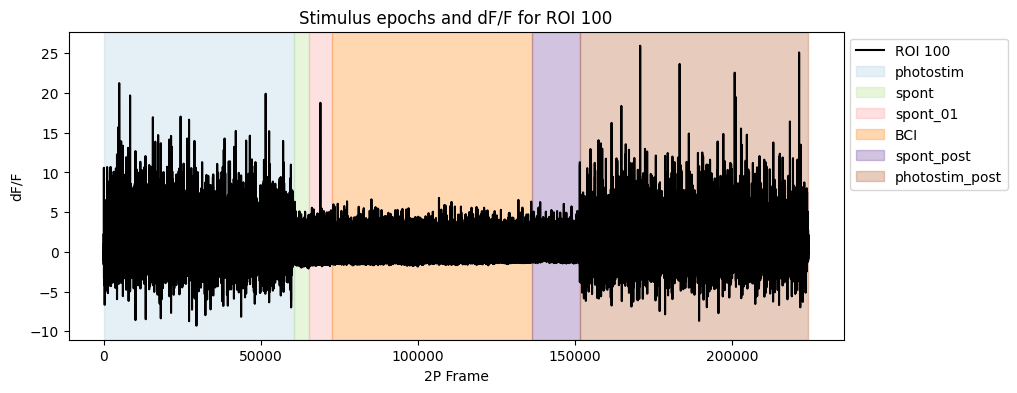

In [19]:
# Pick an ROI
ROI = 100

# Plot dff trace for selected ROI 
plt.rcParams["figure.figsize"] = (10, 4)
plt.plot(dff_traces[:, ROI], label=f'ROI {ROI}', color='black')

# Add shaded regions for stimulus epochs 
epoch_table = nwbfile.intervals["epochs"].to_dataframe()
stimulus_names = epoch_table.stimulus_name.unique()

import matplotlib.cm as cm
colors = cm.get_cmap('Paired')
colors = colors(np.linspace(0, 1, len(stimulus_names)))

                
for c, stimulus_name in enumerate(stimulus_names):
    stim_epoch = epoch_table[epoch_table.stimulus_name==stimulus_name]
    for j in range(len(stim_epoch)):
        plt.axvspan(xmin=stim_epoch.start_frame.iloc[j], xmax=stim_epoch.stop_frame.iloc[j], color=colors[c], alpha=0.3, label=stimulus_name)

plt.ylabel('dF/F')
plt.xlabel('2P Frame')
plt.title('Stimulus epochs and dF/F for ROI '+str(ROI))
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

In [21]:
trials = nwbfile.stimulus["Trials"].to_dataframe()
trials.head()

,start_time,stop_time,go_cue,hit,lick_L,reward_time,threshold_crossing_times,zaber_step_times,tiff_file,start_frame,stop_frame,conditioned_neuron_x,conditioned_neuron_y,closest_roi
id,,,,,,,,,,,,,,
0,1246.940618,1256.517814,0.2359,True,"[2.3813, 2.5164, 2.7018, 2.8349, 2.9623, 6.512...",2.3813,2.2218,"[0.8429000000000001, 1.1209, 1.3099, 1.4559, 1...",neuron57_00001.tif,72651,73209,301.5,21.5,5
1,1256.534977,1264.550301,0.2359,True,"[1.5944, 1.7749, 1.9051, 2.0583, nan, nan, nan...",1.5944,1.5869,"[1.091, 1.149, 1.204, 1.268, 1.3, 1.332, 1.364...",neuron57_00002.tif,73210,73677,301.5,21.5,5
2,1264.567464,1270.969425,0.2359,True,"[1.614, 1.7531, 1.8784, 2.1422, 2.2784, 2.5652...",1.6140,1.5624,"[0.9383, 1.0003, 1.0463, 1.0913000000000002, 1...",neuron57_00003.tif,73678,74051,301.5,21.5,5
3,1270.986588,1279.619796,0.2359,True,"[4.4629, 4.6554, 4.7906, 4.9332, 5.0762, 5.204...",4.4629,4.2891,"[3.8676, 3.9016, 3.9336, 3.9656, 3.9976, 4.029...",neuron57_00004.tif,74052,74555,301.5,21.5,5
4,1279.636959,1286.862765,0.2359,True,"[2.6602, 2.8055000000000003, 2.9299, 3.055, 3....",2.6602,2.5805,"[1.2888000000000002, 1.4287, 1.6897, 1.9167, 2...",neuron57_00005.tif,74556,74977,301.5,21.5,5


In [25]:
trials.closest_roi.unique()

array([5])

/tmp/ipykernel_3113/4025117028.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('Paired')


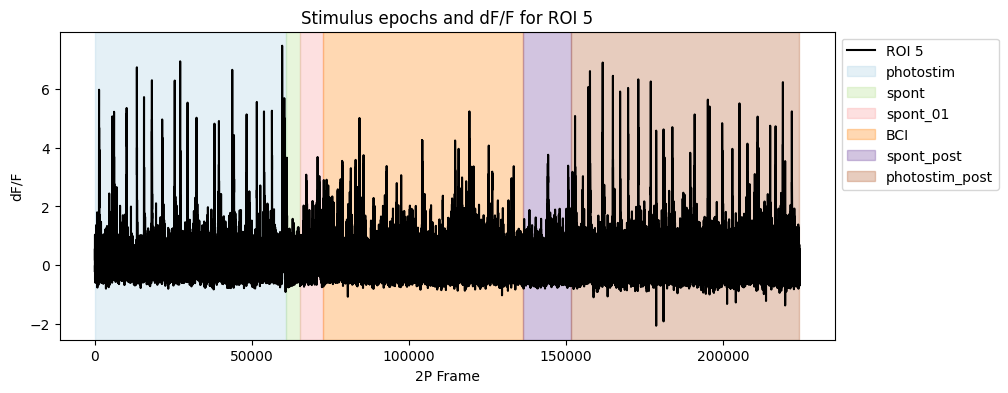

In [27]:
# Pick an ROI
ROI = 5

# Plot dff trace for selected ROI 
plt.rcParams["figure.figsize"] = (10, 4)
plt.plot(dff_traces[:, ROI], label=f'ROI {ROI}', color='black')

# Add shaded regions for stimulus epochs 
epoch_table = nwbfile.intervals["epochs"].to_dataframe()
stimulus_names = epoch_table.stimulus_name.unique()

import matplotlib.cm as cm
colors = cm.get_cmap('Paired')
colors = colors(np.linspace(0, 1, len(stimulus_names)))

                
for c, stimulus_name in enumerate(stimulus_names):
    stim_epoch = epoch_table[epoch_table.stimulus_name==stimulus_name]
    for j in range(len(stim_epoch)):
        plt.axvspan(xmin=stim_epoch.start_frame.iloc[j], xmax=stim_epoch.stop_frame.iloc[j], color=colors[c], alpha=0.3, label=stimulus_name)

plt.ylabel('dF/F')
plt.xlabel('2P Frame')
plt.title('Stimulus epochs and dF/F for ROI '+str(ROI))
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()